# Synthetic Concrete Crack Generation with a Variational Autoencoder (VAE)

## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Dataset and Data Loader Classes

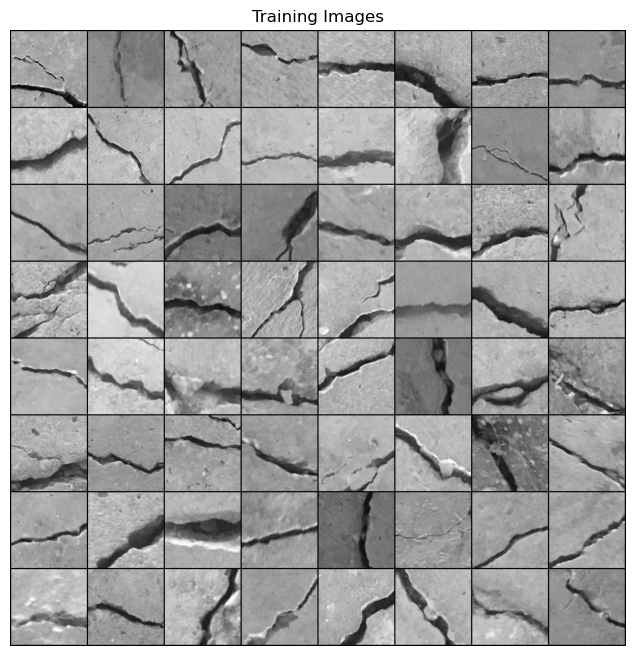

In [2]:
class CrackDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = Path(root_dir)
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.root_dir / self.image_files[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

#####Parameters
IMG_SIZE = 128
BATCH_SIZE = 64
LATENT_DIM = 100

#Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


dataset_path = 'processed_images'

dataset = CrackDataset(root_dir = dataset_path, transform = transform)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)


real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch.to(device)[:64], padding = 2, normalize = True).cpu(),(1,2,0)))
plt.show()

## VAE Model Class

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 4, stride=2, padding=1), # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 4, stride=2, padding=1), # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = 4, stride=2, padding=1), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = 4, stride=2, padding=1), # 16 -> 8
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size = 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logvar = self.fc_logvar(result)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 256, 8, 8)
        return self.decoder(result)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Loss Function

In [4]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, IMG_SIZE*IMG_SIZE), x.view(-1, IMG_SIZE*IMG_SIZE), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

## Model Training

In [ ]:
model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
NUM_EPOCHS = 50 

for epoch in range(NUM_EPOCHS):
    loop = tqdm(dataloader, desc = f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    total_loss = 0
    for data in loop:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, beta=0.5) 
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        loop.set_postfix(loss=loss.item() / len(data))
    
    avg_loss = total_loss / len(dataloader.dataset)
    print(f'Epoch: {epoch+1} Average loss: {avg_loss:.4f}')

print("Training complete.")

Epoch [1/50]: 100%|██████████| 313/313 [02:35<00:00,  2.01it/s, loss=1.04e+4]


Epoch: 1 Average loss: 10388.5033


Epoch [2/50]: 100%|██████████| 313/313 [00:36<00:00,  8.47it/s, loss=1e+4]   


Epoch: 2 Average loss: 10194.8496


Epoch [3/50]: 100%|██████████| 313/313 [00:36<00:00,  8.54it/s, loss=1.02e+4]


Epoch: 3 Average loss: 10165.8464


Epoch [4/50]: 100%|██████████| 313/313 [00:28<00:00, 11.13it/s, loss=1.03e+4]


Epoch: 4 Average loss: 10152.4931


Epoch [5/50]: 100%|██████████| 313/313 [00:20<00:00, 15.35it/s, loss=1e+4]   


Epoch: 5 Average loss: 10147.0451


Epoch [6/50]: 100%|██████████| 313/313 [00:19<00:00, 15.95it/s, loss=9.88e+3]


Epoch: 6 Average loss: 10142.1280


Epoch [7/50]: 100%|██████████| 313/313 [00:18<00:00, 16.66it/s, loss=1.01e+4]


Epoch: 7 Average loss: 10139.3252


Epoch [8/50]: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s, loss=1.02e+4]


Epoch: 8 Average loss: 10137.7470


Epoch [9/50]: 100%|██████████| 313/313 [00:18<00:00, 16.79it/s, loss=1.03e+4]


Epoch: 9 Average loss: 10134.3010


Epoch [10/50]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=1.03e+4]


Epoch: 10 Average loss: 10133.3179


Epoch [11/50]: 100%|██████████| 313/313 [00:18<00:00, 16.68it/s, loss=9.98e+3]


Epoch: 11 Average loss: 10130.8044


Epoch [12/50]: 100%|██████████| 313/313 [00:18<00:00, 16.82it/s, loss=1.03e+4]


Epoch: 12 Average loss: 10130.8779


Epoch [13/50]: 100%|██████████| 313/313 [00:18<00:00, 16.69it/s, loss=1e+4]   


Epoch: 13 Average loss: 10128.8753


Epoch [14/50]: 100%|██████████| 313/313 [00:18<00:00, 17.27it/s, loss=1.01e+4]


Epoch: 14 Average loss: 10127.9187


Epoch [15/50]: 100%|██████████| 313/313 [00:18<00:00, 17.26it/s, loss=1.02e+4]


Epoch: 15 Average loss: 10126.7359


Epoch [16/50]: 100%|██████████| 313/313 [00:30<00:00, 10.36it/s, loss=1e+4]   


Epoch: 16 Average loss: 10126.4215


Epoch [17/50]: 100%|██████████| 313/313 [00:24<00:00, 13.00it/s, loss=1.01e+4]


Epoch: 17 Average loss: 10124.4996


Epoch [18/50]: 100%|██████████| 313/313 [00:18<00:00, 17.29it/s, loss=1.01e+4]


Epoch: 18 Average loss: 10123.9227


Epoch [19/50]: 100%|██████████| 313/313 [00:20<00:00, 15.47it/s, loss=9.97e+3]


Epoch: 19 Average loss: 10123.5511


Epoch [20/50]: 100%|██████████| 313/313 [00:18<00:00, 17.27it/s, loss=1.02e+4]


Epoch: 20 Average loss: 10122.0190


Epoch [21/50]: 100%|██████████| 313/313 [00:20<00:00, 15.41it/s, loss=1.03e+4]


Epoch: 21 Average loss: 10121.2557


Epoch [22/50]: 100%|██████████| 313/313 [00:26<00:00, 11.85it/s, loss=9.9e+3] 


Epoch: 22 Average loss: 10120.9938


Epoch [23/50]: 100%|██████████| 313/313 [00:27<00:00, 11.35it/s, loss=1.02e+4]


Epoch: 23 Average loss: 10119.2615


Epoch [24/50]: 100%|██████████| 313/313 [00:18<00:00, 17.25it/s, loss=1.02e+4]


Epoch: 24 Average loss: 10118.9080


Epoch [25/50]: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s, loss=1.02e+4]


Epoch: 25 Average loss: 10118.1020


Epoch [26/50]: 100%|██████████| 313/313 [00:18<00:00, 16.92it/s, loss=1.03e+4]


Epoch: 26 Average loss: 10118.0030


Epoch [27/50]: 100%|██████████| 313/313 [00:19<00:00, 16.32it/s, loss=1.04e+4]


Epoch: 27 Average loss: 10117.2112


Epoch [28/50]: 100%|██████████| 313/313 [00:18<00:00, 16.84it/s, loss=1e+4]   


Epoch: 28 Average loss: 10115.9150


Epoch [29/50]: 100%|██████████| 313/313 [00:18<00:00, 16.69it/s, loss=1e+4]   


Epoch: 29 Average loss: 10115.5303


Epoch [30/50]: 100%|██████████| 313/313 [00:18<00:00, 16.64it/s, loss=1.01e+4]


Epoch: 30 Average loss: 10114.9769


Epoch [31/50]: 100%|██████████| 313/313 [00:18<00:00, 16.77it/s, loss=1.02e+4]


Epoch: 31 Average loss: 10114.6575


Epoch [32/50]: 100%|██████████| 313/313 [00:19<00:00, 16.45it/s, loss=1.02e+4]


Epoch: 32 Average loss: 10114.1486


Epoch [33/50]: 100%|██████████| 313/313 [00:18<00:00, 16.60it/s, loss=1.04e+4]


Epoch: 33 Average loss: 10113.3211


Epoch [34/50]: 100%|██████████| 313/313 [00:18<00:00, 16.95it/s, loss=1.02e+4]


Epoch: 34 Average loss: 10112.4791


Epoch [35/50]: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s, loss=1.02e+4]


Epoch: 35 Average loss: 10112.3967


Epoch [36/50]: 100%|██████████| 313/313 [00:18<00:00, 16.75it/s, loss=1.02e+4]


Epoch: 36 Average loss: 10111.7794


Epoch [37/50]: 100%|██████████| 313/313 [00:18<00:00, 16.90it/s, loss=1e+4]   


Epoch: 37 Average loss: 10111.1776


Epoch [38/50]: 100%|██████████| 313/313 [00:18<00:00, 16.83it/s, loss=1e+4]   


Epoch: 38 Average loss: 10111.1974


Epoch [39/50]: 100%|██████████| 313/313 [00:18<00:00, 16.84it/s, loss=1.02e+4]


Epoch: 39 Average loss: 10110.2879


Epoch [40/50]: 100%|██████████| 313/313 [00:18<00:00, 16.67it/s, loss=1.03e+4]


Epoch: 40 Average loss: 10110.1813


Epoch [41/50]: 100%|██████████| 313/313 [00:18<00:00, 16.70it/s, loss=9.97e+3]


Epoch: 41 Average loss: 10109.5158


Epoch [42/50]: 100%|██████████| 313/313 [00:25<00:00, 12.27it/s, loss=1.01e+4]


Epoch: 42 Average loss: 10109.0424


Epoch [43/50]: 100%|██████████| 313/313 [00:36<00:00,  8.65it/s, loss=9.99e+3]


Epoch: 43 Average loss: 10108.5959


Epoch [44/50]: 100%|██████████| 313/313 [00:36<00:00,  8.67it/s, loss=9.99e+3]


Epoch: 44 Average loss: 10108.4365


Epoch [45/50]: 100%|██████████| 313/313 [00:35<00:00,  8.70it/s, loss=1.03e+4]


Epoch: 45 Average loss: 10107.8986


Epoch [46/50]: 100%|██████████| 313/313 [00:35<00:00,  8.70it/s, loss=1.01e+4]


Epoch: 46 Average loss: 10107.5417


Epoch [47/50]: 100%|██████████| 313/313 [00:36<00:00,  8.66it/s, loss=1e+4]   


Epoch: 47 Average loss: 10107.3352


Epoch [48/50]: 100%|██████████| 313/313 [00:18<00:00, 16.65it/s, loss=1.01e+4]


Epoch: 48 Average loss: 10106.7489


Epoch [49/50]: 100%|██████████| 313/313 [00:18<00:00, 16.82it/s, loss=1.02e+4]


Epoch: 49 Average loss: 10106.7414


Epoch [50/50]: 100%|██████████| 313/313 [00:18<00:00, 16.99it/s, loss=9.72e+3]

Epoch: 50 Average loss: 10106.1809
Training complete.


# Saving Trained Model

In [8]:
MODEL_PATH = 'vae_crack_generator.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to vae_crack_generator.pth


# Loading the Model

In [9]:
model = VAE(latent_dim=LATENT_DIM).to(device)
MODEL_PATH = 'vae_crack_generator.pth'
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

## Model Evaluation

Top Row: Real Images, Bottom Row: Reconstructed Images


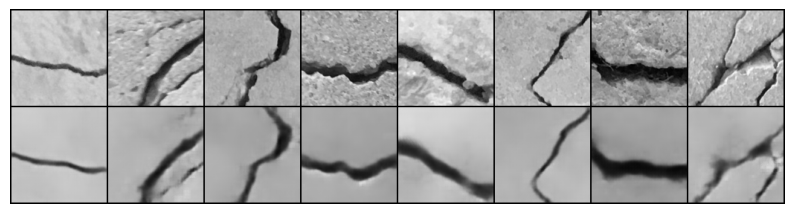

In [14]:
model.eval()
with torch.no_grad():
    real_images = next(iter(dataloader)).to(device)
    reconstructed_images, _, _ = model(real_images)

    comparison = torch.cat([real_images[:8], reconstructed_images.view(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE)[:8]])
    grid = make_grid(comparison, nrow=8, padding=2, normalize=True)
    
    print("Top Row: Real Images, Bottom Row: Reconstructed Images")
    plt.figure(figsize=(10, 3))
    plt.imshow(grid.cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.show()

## Image Generation


Generated Synthetic Crack Images


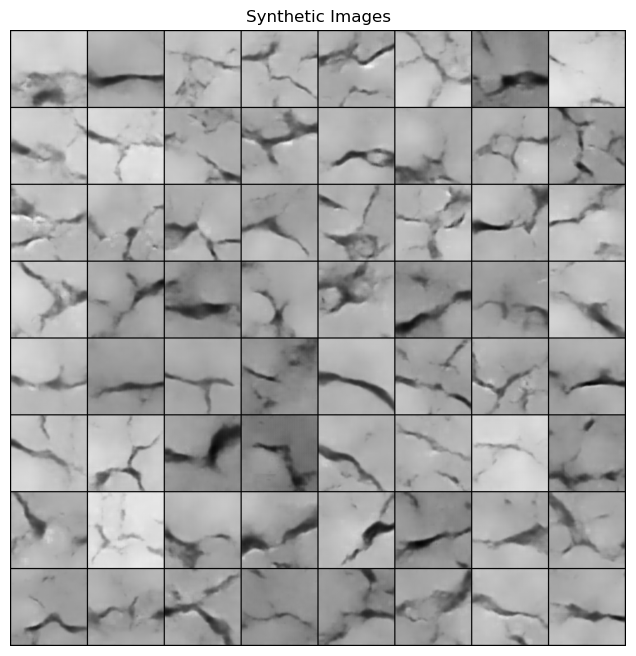

In [15]:
with torch.no_grad():
    z = torch.randn(64, LATENT_DIM).to(device)
    generated_images = model.decode(z).cpu()
    
    print("\nGenerated Synthetic Crack Images")
    grid = make_grid(generated_images, padding=2, normalize=True)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Synthetic Images")
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.show()